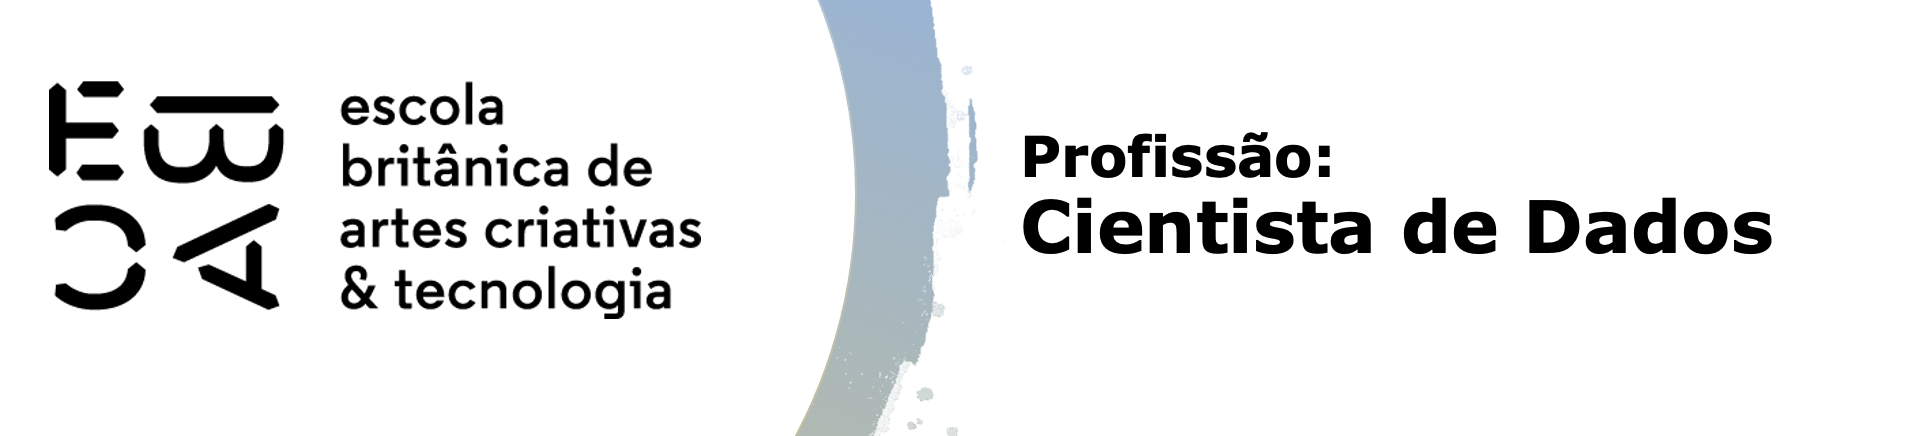

# Árvores II - Tarefa 3

### 1. Carregar as bases

Vamos utilizar nesta tarefa as bases de reconhecimento de atividade humana através do celular. Carregue novamente as bases salvas na tarefa I.

In [77]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline

In [78]:
%%time
# Carregar os dados
X_train = pd.read_csv('X_train.csv', index_col='Unnamed: 0')[['1 tBodyAcc-mean()-X', '2 tBodyAcc-mean()-Y', '3 tBodyAcc-mean()-Z']]
y_train = pd.read_csv('y_train.txt', header=None).squeeze()
X_test = pd.read_csv('X_test.csv', index_col='Unnamed: 0')[['1 tBodyAcc-mean()-X', '2 tBodyAcc-mean()-Y', '3 tBodyAcc-mean()-Z']]
y_test = pd.read_csv('y_test.txt', header=None).squeeze()

# Exibir formatos dos conjuntos de dados
for conjunto, rotulo_dados in zip([X_train, X_test], ['Treino', 'Teste']):
    print(f'Formato de {rotulo_dados}:', conjunto.shape)

Formato de Treino: (7352, 3)
Formato de Teste: (2947, 3)
CPU times: total: 15.6 ms
Wall time: 23.8 ms


### 2. Calcule os ```ccp_alphas```. 

Vamos seguir uma lógica bem em linha com o que já estamso acostumados, com as seguintes orientações:

- Utilizar treinamento e teste conforme já vieram definidos originalmente
- Por pragmatismo, utilizar ```min_samples_leaf=20```
- Utilize as mesmas "3 melhores variáveis" identificadas no exercício anterior.

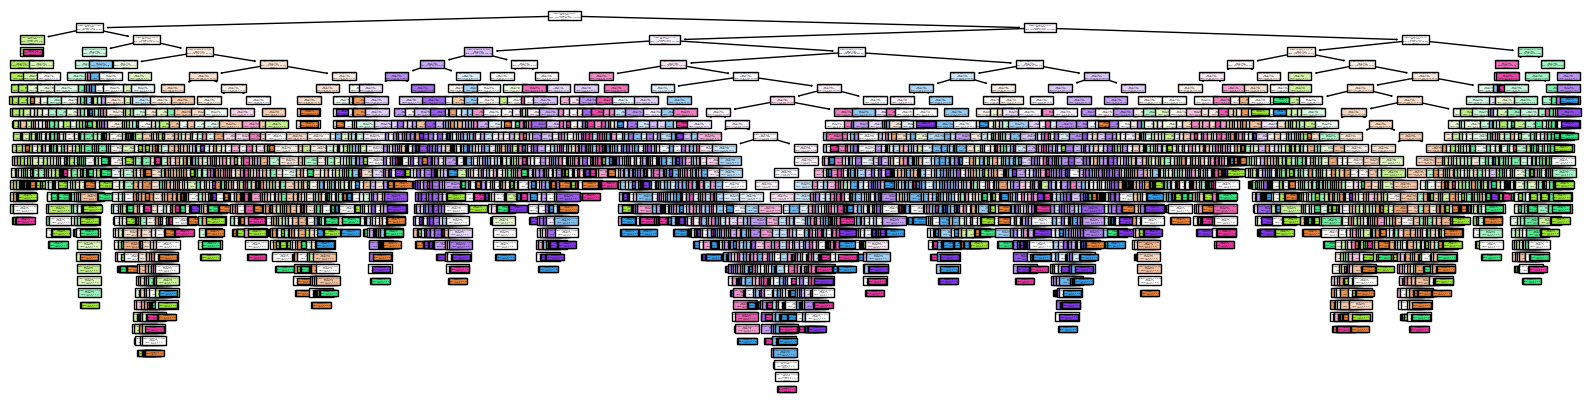

CPU times: total: 1min 25s
Wall time: 1min 47s


In [79]:
%%time
# Treinar a árvore de decisão e plotá-la
arvore_classificadora = DecisionTreeClassifier(random_state=42)
caminho_pruning = arvore_classificadora.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = caminho_pruning.ccp_alphas[caminho_pruning.ccp_alphas >= 0]

plt.figure(figsize=(20, 5))
plot_tree(arvore_classificadora.fit(X_train, y_train), filled=True, feature_names=X_train.columns, class_names=list(map(str, arvore_classificadora.classes_)))
plt.show()

### 3. *Grid Search*

Vou deixar especificações iniciais mínimas, que visam limitar o tempo de máquina, pois um procedimento desses pode demorar muito tempo dependendo da especificação. Mas conforme você for ficando confortável com o tempo consumido pelo procedimento, pode fazer um algoritmo mais exaustivo, por exemplo, avaliando mais valores de ```ccp_alpha```.

- Meça o tempo
- Utilize a base de treinamento
- Utilize um *cross validation* do tipo *k-fold*, especifique k=10
- Você pode ler 1 a cada ```k``` valores para uma melhor varredura utilizando, por exemplo, ```ccp_alpha[::10]```
- Não se esqueça de limitar o número de variáveis

In [80]:
%%time
# Função para treinar e avaliar a árvore de decisão
def treinar_e_avaliar_arvore(X_train, y_train, X_test, y_test, ccp_alphas):
    clf = DecisionTreeClassifier(min_samples_leaf=20, random_state=42)
    grid = GridSearchCV(estimator=clf, param_grid={'ccp_alpha': ccp_alphas[::10]}, cv=10, verbose=1)
    grid.fit(X_train, y_train)
    resultados_df = pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score')
    melhor_ccp = resultados_df.iloc[grid.best_index_]['param_ccp_alpha']
    print('\nVencedor rank_test_score:')
    print('\t mean_test_score:', grid.best_score_)
    print('\t param_ccp_alpha:', melhor_ccp)
    return melhor_ccp

# Treinar e avaliar a árvore de decisão
melhor_ccp_1 = treinar_e_avaliar_arvore(X_train, y_train, X_test, y_test, ccp_alphas)

Fitting 10 folds for each of 165 candidates, totalling 1650 fits

Vencedor rank_test_score:
	 mean_test_score: 0.4562034161490683
	 param_ccp_alpha: 0.00017682263329706207
CPU times: total: 31.2 s
Wall time: 36.3 s


### 4. Avaliando a árvore

- Obtenha a árvore na melhor configuração treinada em toda a base de treino
- Calcule a acurácia dessa árvore na base de testes
- Visualize a matriz de confusão

Acurácia da árvore no conjunto de teste: 0.38853070919579236


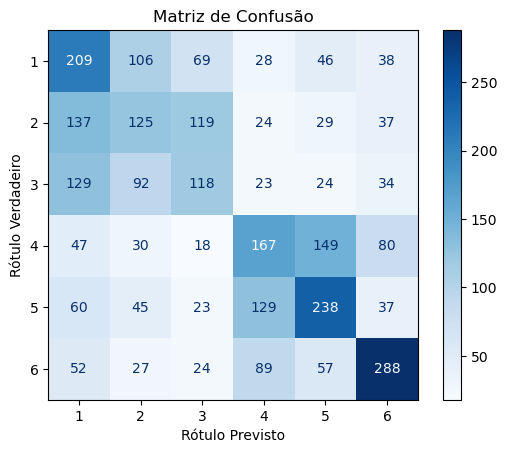

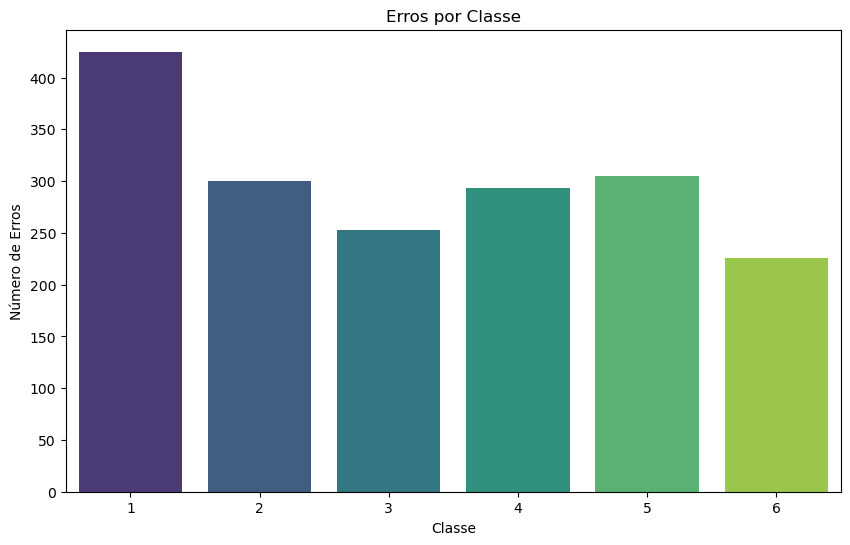

        acertos  erros
classe                
1           209    425
5           238    305
2           125    300
4           167    293
3           118    253
6           288    226
CPU times: total: 312 ms
Wall time: 370 ms


In [81]:
%%time
# Treinar outra árvore de decisão para uma classe específica
clf_1 = DecisionTreeClassifier(random_state=42, ccp_alpha=melhor_ccp_1).fit(X_train, y_train)
acuracia = accuracy_score(y_test, clf_1.predict(X_test))
print('Acurácia da árvore no conjunto de teste:', acuracia)

# Exibir a matriz de confusão
y_pred = clf_1.predict(X_test)
matriz_confusao_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=clf_1.classes_)
matriz_confusao_display.plot(cmap=plt.cm.Blues, values_format=".0f", xticks_rotation='horizontal')
plt.title('Matriz de Confusão')
plt.xlabel('Rótulo Previsto')
plt.ylabel('Rótulo Verdadeiro')
plt.show()

# Analisar erros por classe
matriz_confusao_1 = confusion_matrix(y_true=y_test, y_pred=y_pred)
acertos_1 = [matriz_confusao_1[x, x] for x in range(6)]
erros_1 = sum(matriz_confusao_1) - acertos_1
resultados_df_1 = pd.DataFrame(data={'acertos': acertos_1, 'erros': erros_1}, index=pd.Index(data=list(range(1, 7)), name='classe')).sort_values(by='erros', ascending=False)

# Visualizar erros por classe
plt.figure(figsize=(10, 6))
sns.barplot(x='classe', y='erros', data=resultados_df_1.reset_index(), palette='viridis')
plt.title('Erros por Classe')
plt.xlabel('Classe')
plt.ylabel('Número de Erros')
plt.show()
print(resultados_df_1)

### 5. Melhorando a árvore

A melhor forma de se melhorar um algoritmo é colocando nele novas variáveis que agreguem valor. Podemos usar a força-bruta e ir colocando variáveis aleatoriamente - ou colocar todas e deixar rodando por um bom tempo - ou utilizar uma lógica eficiente e fazer uma seleção de variáveis.

- Observe que há classes mais fáceis e mais difíceis de se identificar
- Crie uma variável binária para uma das classes de maior erro
- Fala uma árvore de classificação bem simples para esta variável:
    - utilize ```mean_samples_leaf=20```
    - utilize ```max_depth=4```
    - coloque todas as variáveis
- Observe a importância das variáveis, e selecione as 3 com maior importância
- Rode novamente o algoritmo acima com as 3 novas variáveis e avalie a acurácia

Top 3 características para a nova variável: Index(['1 tBodyAcc-mean()-X', '2 tBodyAcc-mean()-Y', '3 tBodyAcc-mean()-Z'], dtype='object') 

X_train_2_dificil: 
 Index(['1 tBodyAcc-mean()-X', '2 tBodyAcc-mean()-Y', '3 tBodyAcc-mean()-Z',
       '1 tBodyAcc-mean()-X', '2 tBodyAcc-mean()-Y', '3 tBodyAcc-mean()-Z'],
      dtype='object')
X_test_2_dificil: 
 Index(['1 tBodyAcc-mean()-X', '2 tBodyAcc-mean()-Y', '3 tBodyAcc-mean()-Z',
       '1 tBodyAcc-mean()-X', '2 tBodyAcc-mean()-Y', '3 tBodyAcc-mean()-Z'],
      dtype='object')
Fitting 10 folds for each of 31 candidates, totalling 310 fits

Vencedor rank_test_score:
	 mean_test_score: 0.8412671916592724
	 param_ccp_alpha: 0.0004663454064977461
          Top 3 características para a nova variável  \
0  Index(['1 tBodyAcc-mean()-X', '2 tBodyAcc-mean...   

                                   X_train_2_dificil  \
0  Index(['1 tBodyAcc-mean()-X', '2 tBodyAcc-mean...   

                                    X_test_2_dificil  \
0  Index(['1 tBodyA

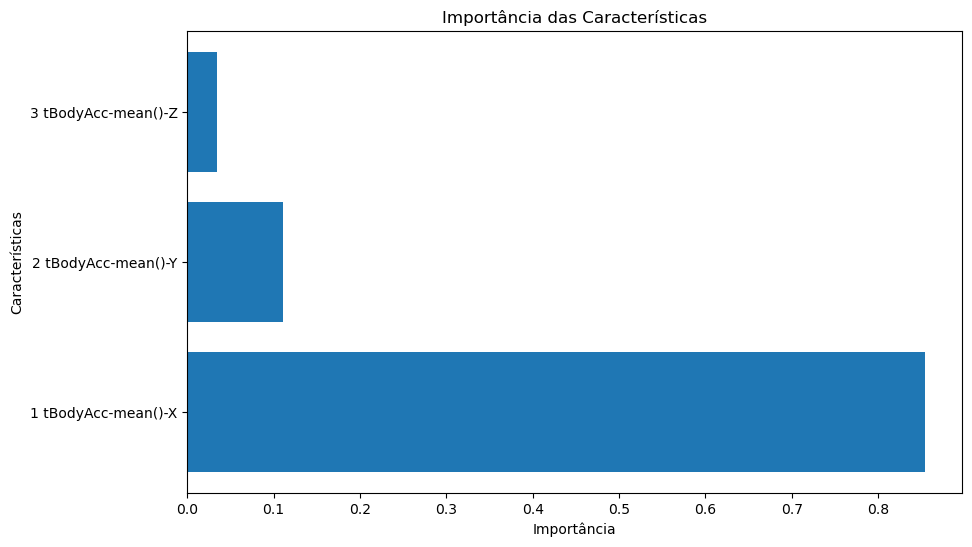

CPU times: total: 18.1 s
Wall time: 21.8 s


In [82]:
%%time
# Função para treinar uma árvore de decisão para uma classe específica
def treinar_arvore(X_train, y_train, min_samples_leaf=20, max_depth=4, random_state=42):
    return DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, max_depth=max_depth, random_state=random_state).fit(X_train, y_train)

# Treinar uma árvore de decisão para uma classe difícil
clf_2 = treinar_arvore(X_train=X_train, y_train=y_train)
classe_dificil = 5  # Substituir pelo número da classe difícil
nova_variavel = f'Classe_{classe_dificil}_Dificil'
y_train_dificil = (y_train == classe_dificil).astype(int)
y_test_dificil = (y_test == classe_dificil).astype(int)
clf_dificil = treinar_arvore(X_train=X_train, y_train=y_train_dificil)

# Analisar a importância das características para a classe difícil
importancias_dificil = pd.Series(clf_dificil.feature_importances_, index=X_train.columns)
cols_dificil = importancias_dificil.nlargest(3).index
print('Top 3 características para a nova variável:', cols_dificil, '\n')

# Combinar colunas selecionadas
cols_2_dificil = cols + cols_dificil.tolist()
X_train_2_dificil, X_test_2_dificil = X_train[cols_2_dificil], X_test[cols_2_dificil]
print('X_train_2_dificil: \n', X_train_2_dificil.columns)
print('X_test_2_dificil: \n', X_test_2_dificil.columns)

# Treinar e avaliar a árvore de decisão para a classe difícil
caminho_2_dificil = DecisionTreeClassifier(random_state=42).cost_complexity_pruning_path(X=X_train_2_dificil, y=y_train_dificil)
ccp_alphas_2_dificil = np.unique(caminho_2_dificil.ccp_alphas[caminho_2_dificil.ccp_alphas >= 0])
melhor_ccp_2_dificil = treinar_e_avaliar_arvore(X_train_2_dificil, y_train_dificil, X_test_2_dificil, y_test_dificil, ccp_alphas_2_dificil)

# Criar um DataFrame para melhor visualização dos resultados
resultados_df_dificil = pd.DataFrame({
    'Top 3 características para a nova variável': [cols_dificil],
    'X_train_2_dificil': [X_train_2_dificil.columns],
    'X_test_2_dificil': [X_test_2_dificil.columns],
    'Melhor ccp_alpha para a nova variável': [melhor_ccp_2_dificil]
})
print(resultados_df_dificil)

# Visualizar a importância das características para a classe difícil
def visualizar_importancia(features, importancias, top_n=3):
    plt.figure(figsize=(10, 6))
    plt.barh(features, importancias.nlargest(top_n))
    plt.title('Importância das Características')
    plt.xlabel('Importância')
    plt.ylabel('Características')
    plt.show()

clf_2 = train_tree(X_train=_X_train, y_train=y_train)
class_difficult = 5  # Replace with the number of the difficult class
nova_variavel = f'Classe_{class_difficult}_Dificil'
y_train_difficult = (y_train == class_difficult).astype(int)
y_test_difficult = (y_test == class_difficult).astype(int)
clf_difficult = train_tree(X_train=_X_train, y_train=y_train_difficult)
importancias_difficult = pd.Series(clf_difficult.feature_importances_, index=_X_train.columns)
cols_difficult = importancias_difficult.nlargest(3).index
print('Top 3 características para nova variável:', cols_difficult, '\n')
cols_2_difficult = cols + cols_difficult.tolist()
X_train_2_difficult, X_test_2_difficult = _X_train[cols_2_difficult], _X_test[cols_2_difficult]
print('X_train_2_difficult: \n', X_train_2_difficult.columns)
print('X_test_2_difficult: \n', X_test_2_difficult.columns)
caminho_2_difficult = DecisionTreeClassifier(random_state=42).cost_complexity_pruning_path(X=X_train_2_difficult, y=y_train_difficult)
ccp_alphas_2_difficult = np.unique(caminho_2_difficult.ccp_alphas[caminho_2_difficult.ccp_alphas >= 0])
melhor_ccp_2_difficult = evaluate_tree(X_train_2_difficult, y_train_difficult, X_test_2_difficult, y_test_difficult, ccp_alphas_2_difficult)
resultados_df_difficult = pd.DataFrame({
    'Top 3 características para nova variável': [cols_difficult],
    'X_train_2_difficult': [X_train_2_difficult.columns],
    'X_test_2_difficult': [X_test_2_difficult.columns],
    'Melhor ccp_alpha para nova variável': [melhor_ccp_2_difficult]
})
print(resultados_df_difficult)
visualize_importance(cols_difficult, importancias_difficult)